**1. Install & Imports**

In [2]:
!pip install scikit-learn pandas numpy matplotlib seaborn



In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.svm import SVC


**2. Column Names (NSL-KDD)**

In [4]:
columns = [
'duration','protocol_type','service','flag','src_bytes','dst_bytes','land',
'wrong_fragment','urgent','hot','num_failed_logins','logged_in',
'num_compromised','root_shell','su_attempted','num_root',
'num_file_creations','num_shells','num_access_files','num_outbound_cmds',
'is_host_login','is_guest_login','count','srv_count','serror_rate',
'srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate',
'diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count',
'dst_host_same_srv_rate','dst_host_diff_srv_rate',
'dst_host_same_src_port_rate','dst_host_srv_diff_host_rate',
'dst_host_serror_rate','dst_host_srv_serror_rate',
'dst_host_rerror_rate','dst_host_srv_rerror_rate',
'label','difficulty'
]


**3. Load Dataset**

In [5]:
df = pd.read_csv("/content/KDDTrain+_20Percent.txt", names=columns)

print("Dataset Shape:", df.shape)
df.head()


Dataset Shape: (25192, 43)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,difficulty
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


**4. Binary Label Conversion**

In [6]:
df['label'] = df['label'].apply(lambda x: 0 if x == 'normal' else 1)

print(df['label'].value_counts())


label
0    13449
1    11743
Name: count, dtype: int64


**5.One-Hot Encoding (CRITICAL)**

In [7]:
df = pd.get_dummies(df, columns=['protocol_type','service','flag'])


**6. Train-Test Split + Scaling**

In [8]:
X = df.drop(['label','difficulty'], axis=1)
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


**7. Logistic Regression (Baseline)**

In [9]:
lr = LogisticRegression(max_iter=2000)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

print("Logistic Regression Results")
print(classification_report(y_test, lr_pred))


Logistic Regression Results
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      3362
           1       0.98      0.96      0.97      2936

    accuracy                           0.97      6298
   macro avg       0.97      0.97      0.97      6298
weighted avg       0.97      0.97      0.97      6298



**8. Random Forest (MAIN MODEL)**

In [10]:
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

print("Random Forest Results")
print(classification_report(y_test, rf_pred))


Random Forest Results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3362
           1       1.00      1.00      1.00      2936

    accuracy                           1.00      6298
   macro avg       1.00      1.00      1.00      6298
weighted avg       1.00      1.00      1.00      6298



**9. SVM (Comparison)**

In [11]:
svm = SVC(kernel='rbf', probability=True)
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)

print("SVM Results")
print(classification_report(y_test, svm_pred))


SVM Results
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3362
           1       0.99      0.99      0.99      2936

    accuracy                           0.99      6298
   macro avg       0.99      0.99      0.99      6298
weighted avg       0.99      0.99      0.99      6298



**10. Confusion Matrix (Random Forest)**

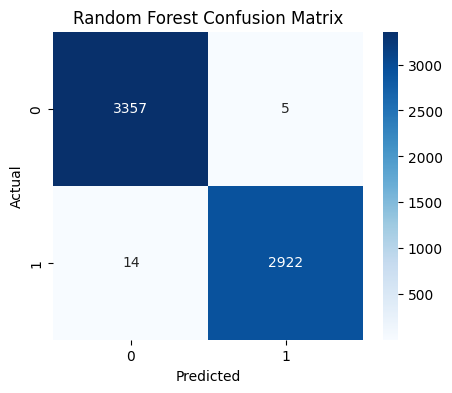

In [12]:
cm = confusion_matrix(y_test, rf_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Confusion Matrix")
plt.show()


**11. Anomaly Detection (Isolation Forest)**

In [13]:
# Train only on NORMAL traffic
X_normal = X_train[y_train == 0]

iso = IsolationForest(
    contamination=0.1,
    random_state=42
)

iso.fit(X_normal)

iso_pred = iso.predict(X_test)
iso_pred = np.where(iso_pred == -1, 1, 0)  # 1 = anomaly


**12. Simulated Real-Time Alerts (Batch = 50)**

In [14]:
alerts = []

batch_size = 50

for i in range(0, len(X_test), batch_size):
    rf_batch = rf_pred[i:i+batch_size]
    iso_batch = iso_pred[i:i+batch_size]

    for j in range(len(rf_batch)):
        if rf_batch[j] == 1 and iso_batch[j] == 1:
            alerts.append("CRITICAL: Confirmed Intrusion Detected")
        elif rf_batch[j] == 1:
            alerts.append("HIGH: Suspicious Traffic Detected")
        elif iso_batch[j] == 1:
            alerts.append("MEDIUM: Anomalous Behavior Detected")
        else:
            alerts.append("SAFE: Normal Traffic")

alerts[:10]


['CRITICAL: Confirmed Intrusion Detected',
 'SAFE: Normal Traffic',
 'SAFE: Normal Traffic',
 'CRITICAL: Confirmed Intrusion Detected',
 'CRITICAL: Confirmed Intrusion Detected',
 'SAFE: Normal Traffic',
 'SAFE: Normal Traffic',
 'SAFE: Normal Traffic',
 'SAFE: Normal Traffic',
 'CRITICAL: Confirmed Intrusion Detected']

**13. Save Alerts Log**

In [15]:
with open("alerts.log", "w") as f:
    for alert in alerts:
        f.write(alert + "\n")

print("alerts.log generated")


alerts.log generated


**14. Final Metrics Summary**

In [16]:
summary = {
    "Model": ["Logistic Regression","Random Forest","SVM"],
    "Accuracy": [
        accuracy_score(y_test, lr_pred),
        accuracy_score(y_test, rf_pred),
        accuracy_score(y_test, svm_pred)
    ],
    "Precision": [
        precision_score(y_test, lr_pred),
        precision_score(y_test, rf_pred),
        precision_score(y_test, svm_pred)
    ],
    "Recall": [
        recall_score(y_test, lr_pred),
        recall_score(y_test, rf_pred),
        recall_score(y_test, svm_pred)
    ],
    "F1-Score": [
        f1_score(y_test, lr_pred),
        f1_score(y_test, rf_pred),
        f1_score(y_test, svm_pred)
    ]
}

pd.DataFrame(summary)


,Model,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,0.971578,0.976166,0.962534,0.969302
1,Random Forest,0.996983,0.998292,0.995232,0.996759
2,SVM,0.989520,0.986441,0.991144,0.988787


In [17]:
import joblib

joblib.dump(rf, "rf_model.pkl")
joblib.dump(iso, "iso_model.pkl")
joblib.dump(scaler, "scaler.pkl")

print("Models saved")


Models saved


In [18]:
import pandas as pd

columns = [
'duration','protocol_type','service','flag','src_bytes','dst_bytes','land',
'wrong_fragment','urgent','hot','num_failed_logins','logged_in',
'num_compromised','root_shell','su_attempted','num_root',
'num_file_creations','num_shells','num_access_files','num_outbound_cmds',
'is_host_login','is_guest_login','count','srv_count','serror_rate',
'srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate',
'diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count',
'dst_host_same_srv_rate','dst_host_diff_srv_rate',
'dst_host_same_src_port_rate','dst_host_srv_diff_host_rate',
'dst_host_serror_rate','dst_host_srv_serror_rate',
'dst_host_rerror_rate','dst_host_srv_rerror_rate',
'label','difficulty'
]

df = pd.read_csv("KDDTrain+_20Percent.txt", names=columns)
df.to_csv("nsl_kdd_upload.csv", index=False)


In [19]:
feature_columns = X.columns
joblib.dump(feature_columns, "feature_columns.pkl")



['feature_columns.pkl']